In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
import matplotlib.style as style
style.use('fivethirtyeight')

In [2]:
train=pd.read_csv('Train.csv')
train_org=train.copy()
test=pd.read_csv('Test.csv')
test_org=test.copy()

In [3]:
train.shape, test.shape

((18288, 3), (5112, 2))

In [4]:
train.head(), train.dtypes

(   ID          Datetime  Count
 0   0  25-08-2012 00:00      8
 1   1  25-08-2012 01:00      2
 2   2  25-08-2012 02:00      6
 3   3  25-08-2012 03:00      2
 4   4  25-08-2012 04:00      2,
 ID           int64
 Datetime    object
 Count        int64
 dtype: object)

In [5]:
test.head(), test.dtypes

(      ID          Datetime
 0  18288  26-09-2014 00:00
 1  18289  26-09-2014 01:00
 2  18290  26-09-2014 02:00
 3  18291  26-09-2014 03:00
 4  18292  26-09-2014 04:00,
 ID           int64
 Datetime    object
 dtype: object)

In [6]:
train.drop(['ID'], axis=1, inplace=True)
test.drop(['ID'], axis=1, inplace=True)
train.Timestamp=pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
test.Timestamp=pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
train.index=train.Timestamp
test.index=test.Timestamp
X=train.iloc[:int(0.7*(len(train)))]
valid=train.iloc[int(0.7*(len(train))):]

In [7]:
X.drop(['Datetime'], axis=1, inplace=True)
valid.drop(['Datetime'], axis=1, inplace=True)
test.drop(['Datetime'], axis=1, inplace=True)

In [8]:
X=X.resample('D').mean()

In [9]:
valid=valid.resample('D').mean()

In [47]:

train.set_index(['Datetime'], inplace=True)
train=train.resample('D').mean()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

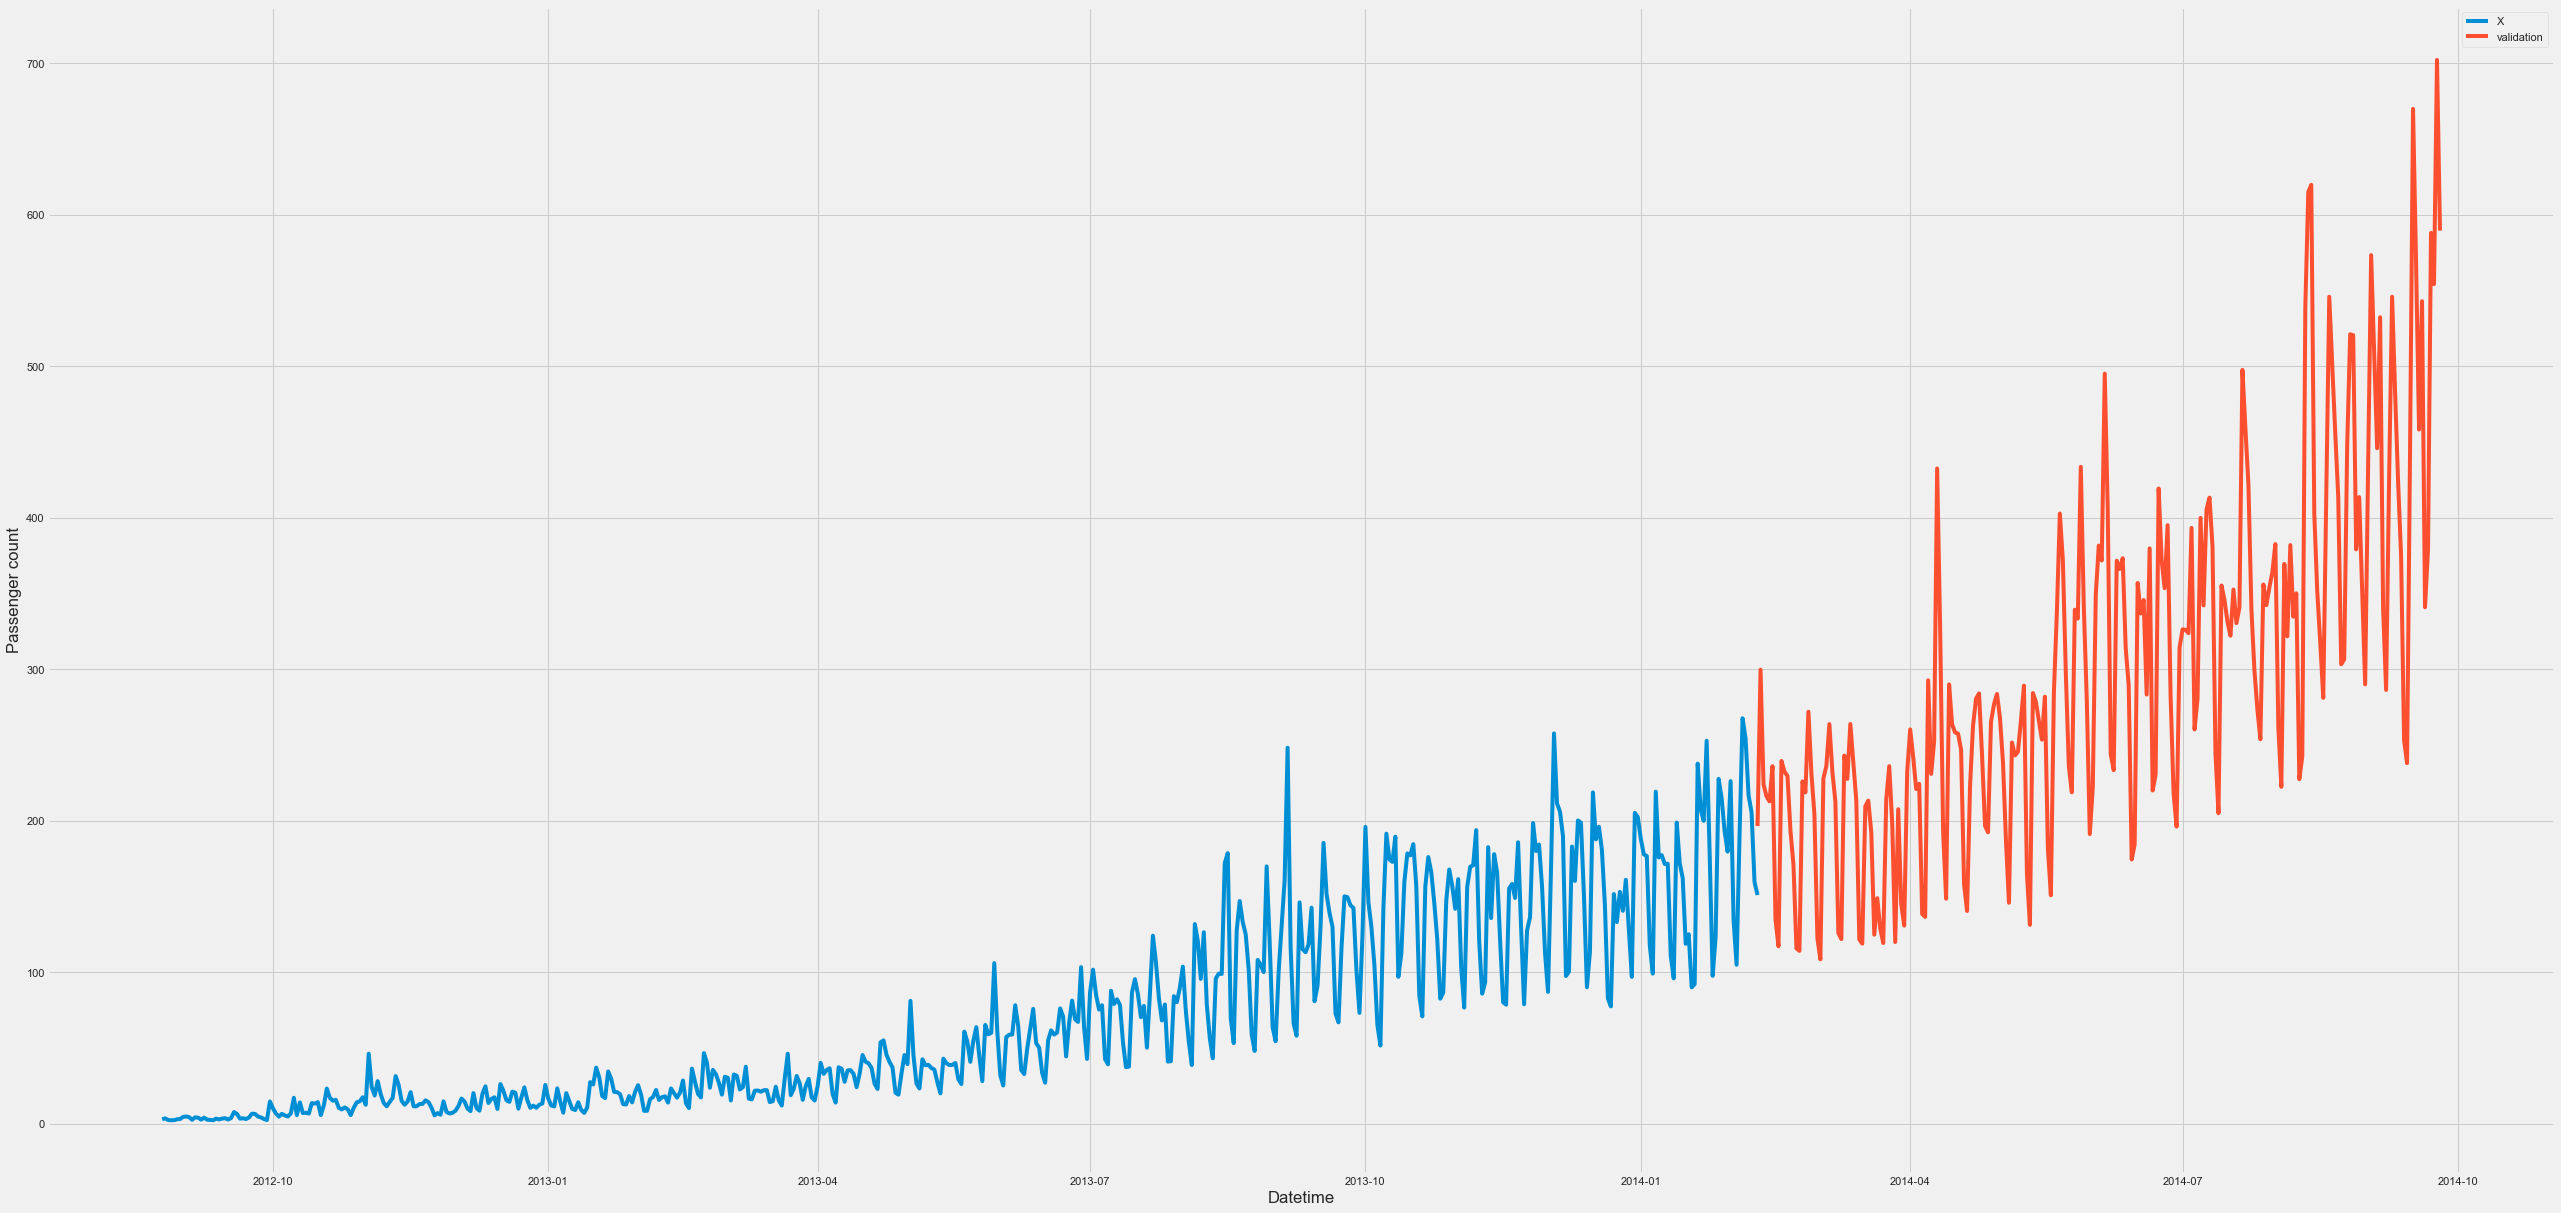

In [10]:
plt.figure(figsize=(40, 20))
plt.plot(X.index, X['Count'], label='X')
plt.plot(valid.index, valid['Count'], label='validation')
plt.xlabel('Datetime')
plt.ylabel('Passenger count')
plt.legend(loc='best')
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import matplotlib
def test_stationarity(timeseries):
    # determing rolling(moving) statistics
    rolmean=timeseries.rolling(window=7).mean()
    rolstd=timeseries.rolling(window=7).std()
    #ploting rolling statistics
    plt.figure(figsize=(40,20))
    matplotlib.rc('xtick', labelsize=30)
    matplotlib.rc('ytick', labelsize=40)
    orig= plt.plot(timeseries, color='blue', label='Original')
    mean=plt.plot(rolmean, color='red', label='Rolling Mean')
    std=plt.plot(rolstd, color='black', label='Rolling STD')
    matplotlib.rc('xtick', labelsize=30)
    matplotlib.rc('ytick', labelsize=40)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey_Fuller test
    print ("result of DIckey_Fuller test:")
    dftest= adfuller(timeseries, autolag= 'AIC')
    dfoutput_1= pd.Series(dftest[0:4], index= ['Test Statistics', 'p-Value', '#lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput_1['Critical Value (%s)'%key]=value
    print (dfoutput_1)
    #Perform KPSS
    print ("result of KPSS test:")
    dftest= kpss(timeseries, regression= 'c')
    dfoutput_2= pd.Series(dftest[0:3], index= ['Test Statistics', 'p-Value', '#lags Used'])
    for key, value in dftest[3].items():
        dfoutput_2['Critical Value (%s)'%key]=value
    print (dfoutput_2)

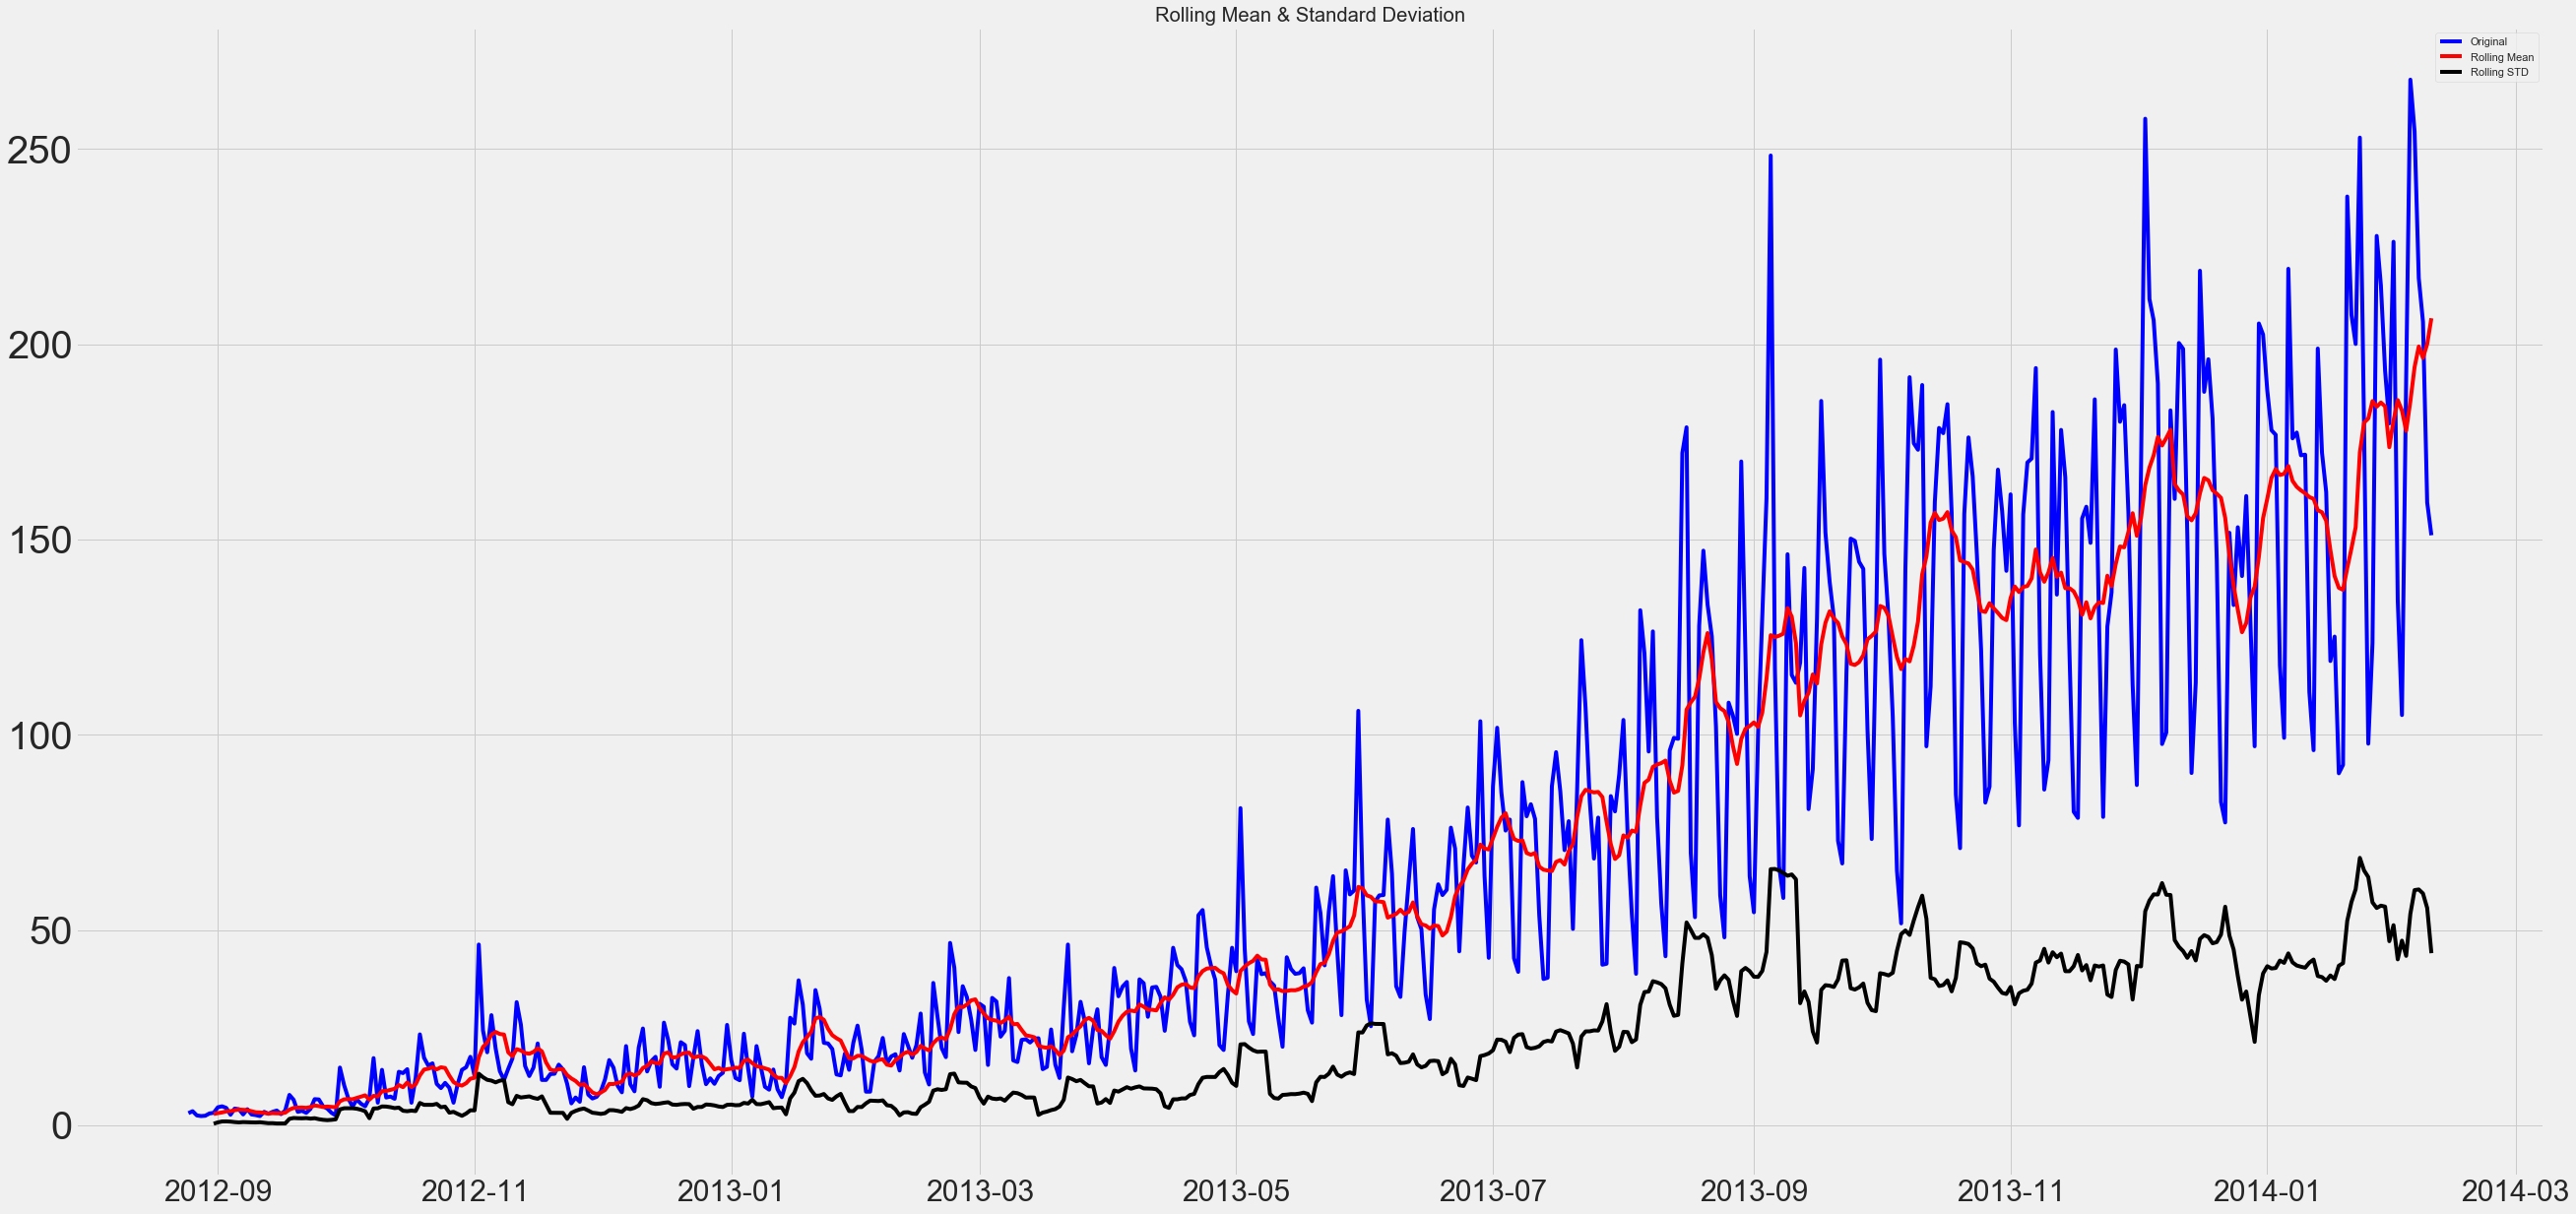

result of DIckey_Fuller test:
Test Statistics                  1.183950
p-Value                          0.995873
#lags Used                      19.000000
Number of Observations Used    514.000000
Critical Value (1%)             -3.443136
Critical Value (5%)             -2.867179
Critical Value (10%)            -2.569774
dtype: float64
result of KPSS test:
Test Statistics           2.634184
p-Value                   0.010000
#lags Used               19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [12]:
test_stationarity(X)

### t-statistic > critical values therefore it fails to reject the null, time series is not stationary 

### t-statistic > critical values for kpss that meens we reject the null (contrary to Dickey Fuller null assumption) and the time series is not Stationary

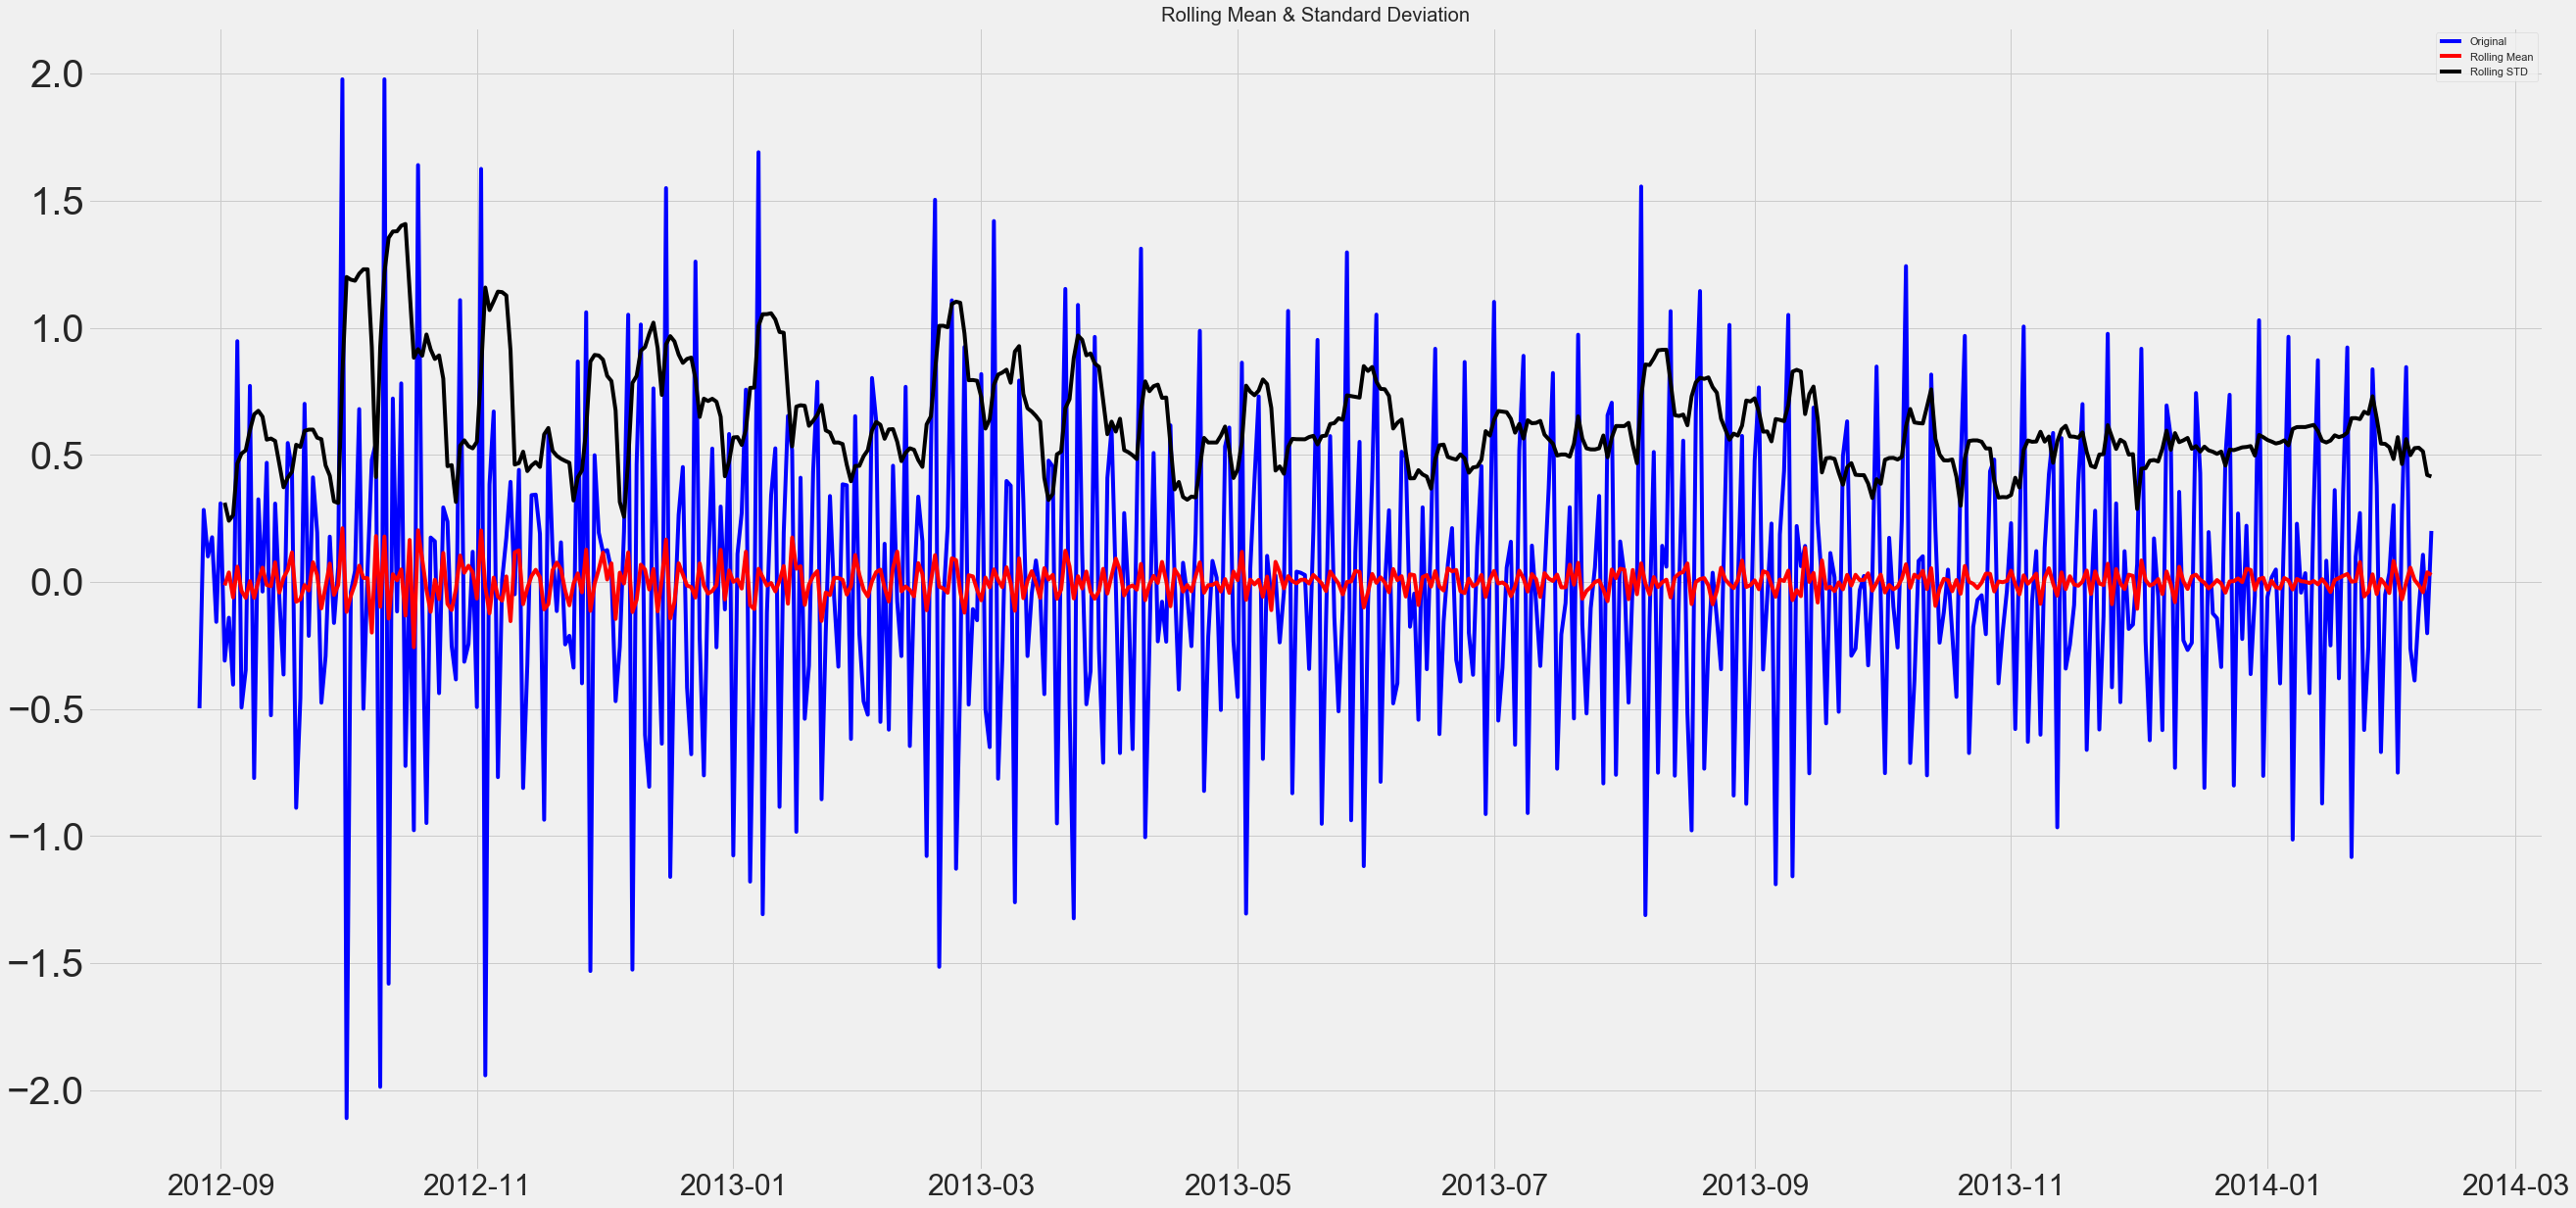

result of DIckey_Fuller test:
Test Statistics               -9.462429e+00
p-Value                        4.317932e-16
#lags Used                     1.900000e+01
Number of Observations Used    5.120000e+02
Critical Value (1%)           -3.443187e+00
Critical Value (5%)           -2.867202e+00
Critical Value (10%)          -2.569785e+00
dtype: float64
result of KPSS test:
Test Statistics           0.018775
p-Value                   0.100000
#lags Used               19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [32]:
# to decrease the variation and trend of the time series we can tranform it.
# log transformation outperformed sqrt and cube and was slightly better than boxcox
X_log=np.log(X['Count'])
# to eliminate trend we can perform differencing method, n=1
# to eliminate trend and seasonality we can perform differencing method considering seanality, e.g n=7
# how ever defferencing method with order of 2 produced better results 
X_log_diff=X_log-X_log.shift(1)
X_log_diff=X_log_diff-X_log_diff.shift(1)
test_stationarity(X_log_diff.dropna())

In [14]:
#from scipy.stats import boxcox
#X_bc=pd.DataFrame(boxcox(X['Count'])[0], index=X.index, columns=['Count'])
#test_stationarity(X_bc)

In [15]:
#X_cube=X['Count']**(1./3)
#X_cube=X_cube-X_cube.shift(1)
#X_cube=X_cube-X_cube.shift(1)
#test_stationarity(X_cube.dropna())

In [16]:
#X_sqrt=np.sqrt(X['Count'])
#X_sqrt=X_sqrt-X_sqrt.shift(1)
#X_sqrt=X_sqrt-X_sqrt.shift(1)
#test_stationarity(X_sqrt)

### Differencing with the order of 2 outputs a better result, so we stick to this

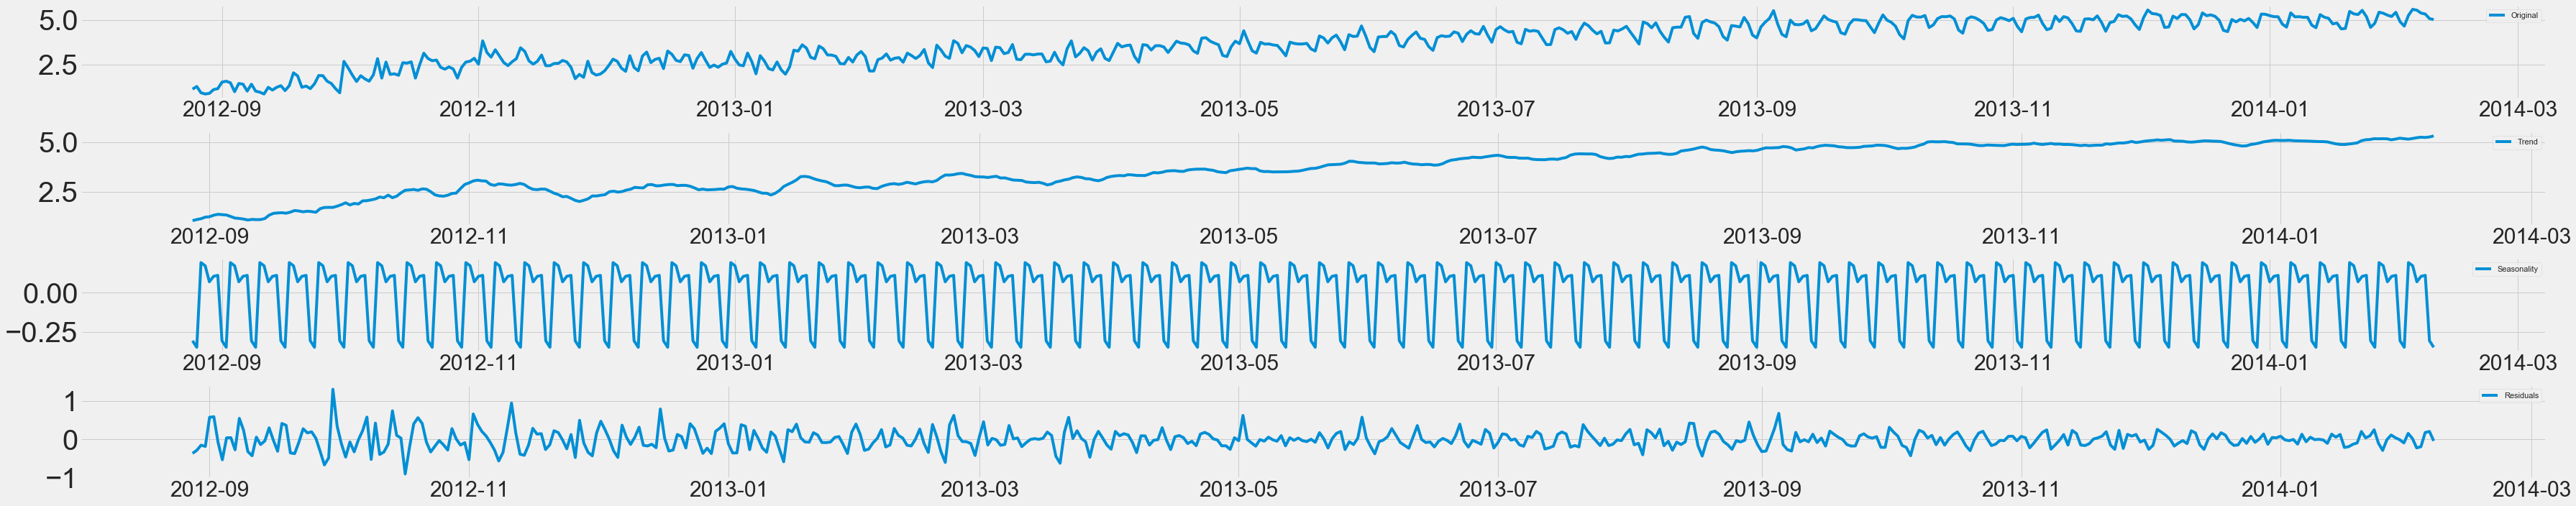

In [27]:
X_log=np.log(X['Count'])
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(pd.DataFrame(X_log).Count.values, freq = 7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(50,10))
plt.subplot(411)
plt.plot(X_log.index, X_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(X_log.index, trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(X_log.index, seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(X_log.index, residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

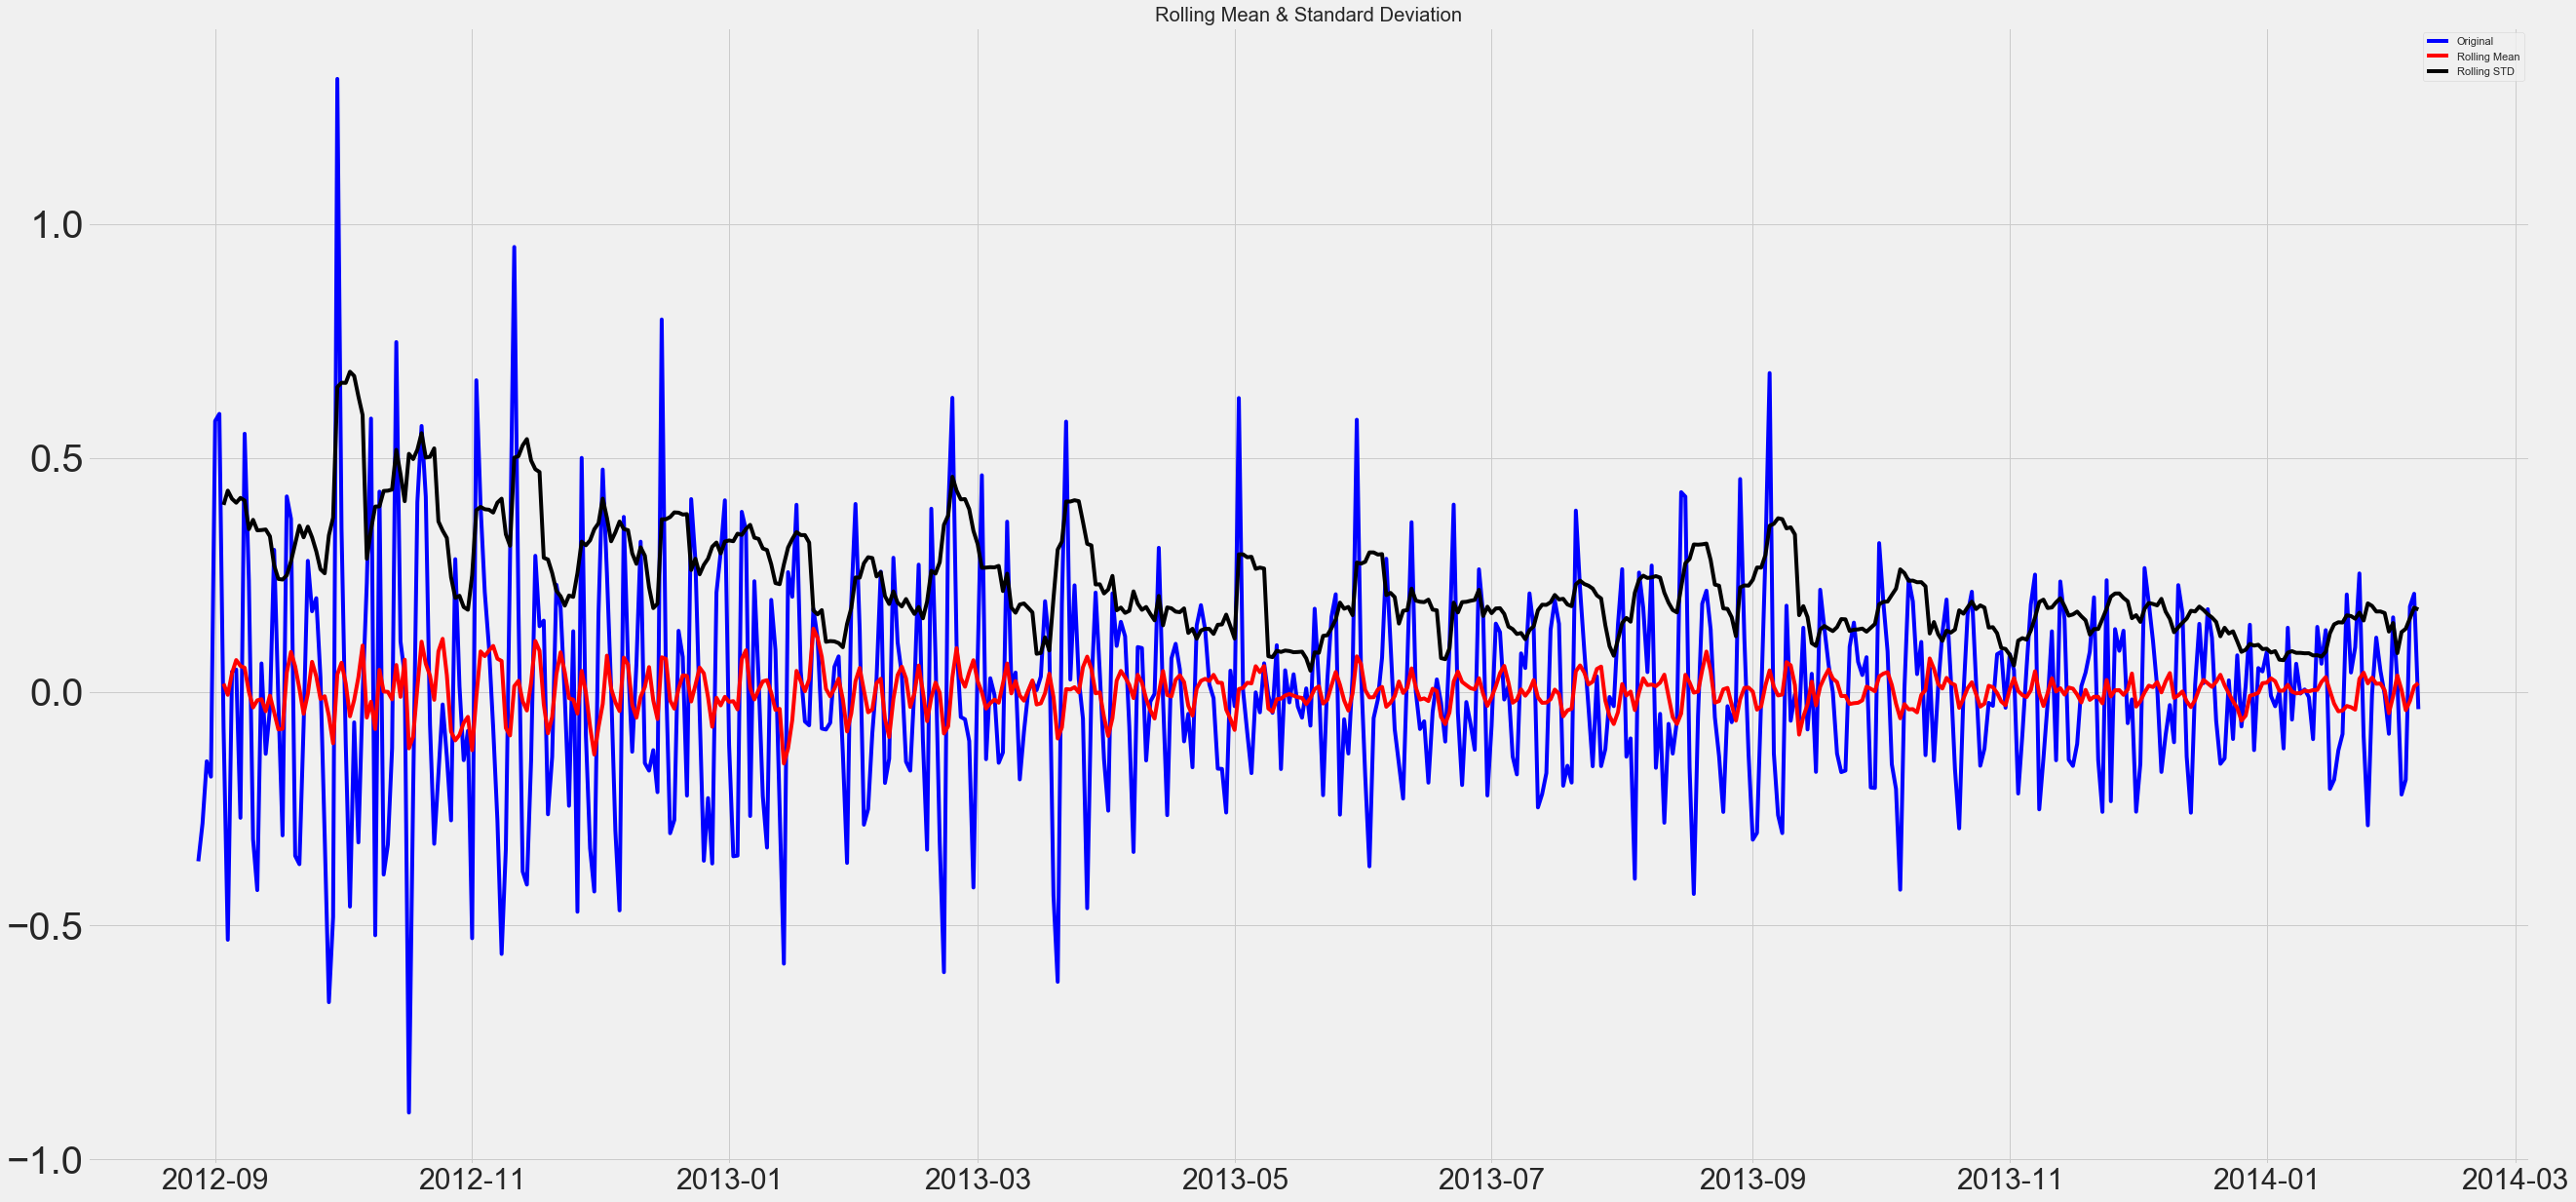

result of DIckey_Fuller test:
Test Statistics               -9.686934e+00
p-Value                        1.163819e-16
#lags Used                     1.900000e+01
Number of Observations Used    5.080000e+02
Critical Value (1%)           -3.443288e+00
Critical Value (5%)           -2.867246e+00
Critical Value (10%)          -2.569809e+00
dtype: float64
result of KPSS test:
Test Statistics           0.036795
p-Value                   0.100000
#lags Used               19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [30]:
X_log_decomp=pd.DataFrame(residual)
X_log_decomp['Datetime']=X_log.index
X_log_decomp.set_index('Datetime', inplace=True)
X_log_decomp.dropna(inplace=True)
test_stationarity(X_log_decomp)


### again differencing produces better results than decomposing and scalling back the series is earier by differencing method. 

## Forecasting timeseries using Auto ARIMA
### there is no need to making series stationary

In [48]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(X['Count'], alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(X['Count'], alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


In [50]:
import pmdarima as pm
AARIMA= pm.auto_arima(X, d=1, trace=False)
AARIMA.fit(X)
forecast=AARIMA.predict(n_periods= len(valid))
forecast=pd.DataFrame(forecast, index=valid.index, columns=['prediction'])
print(AARIMA.order)

(5, 1, 5)


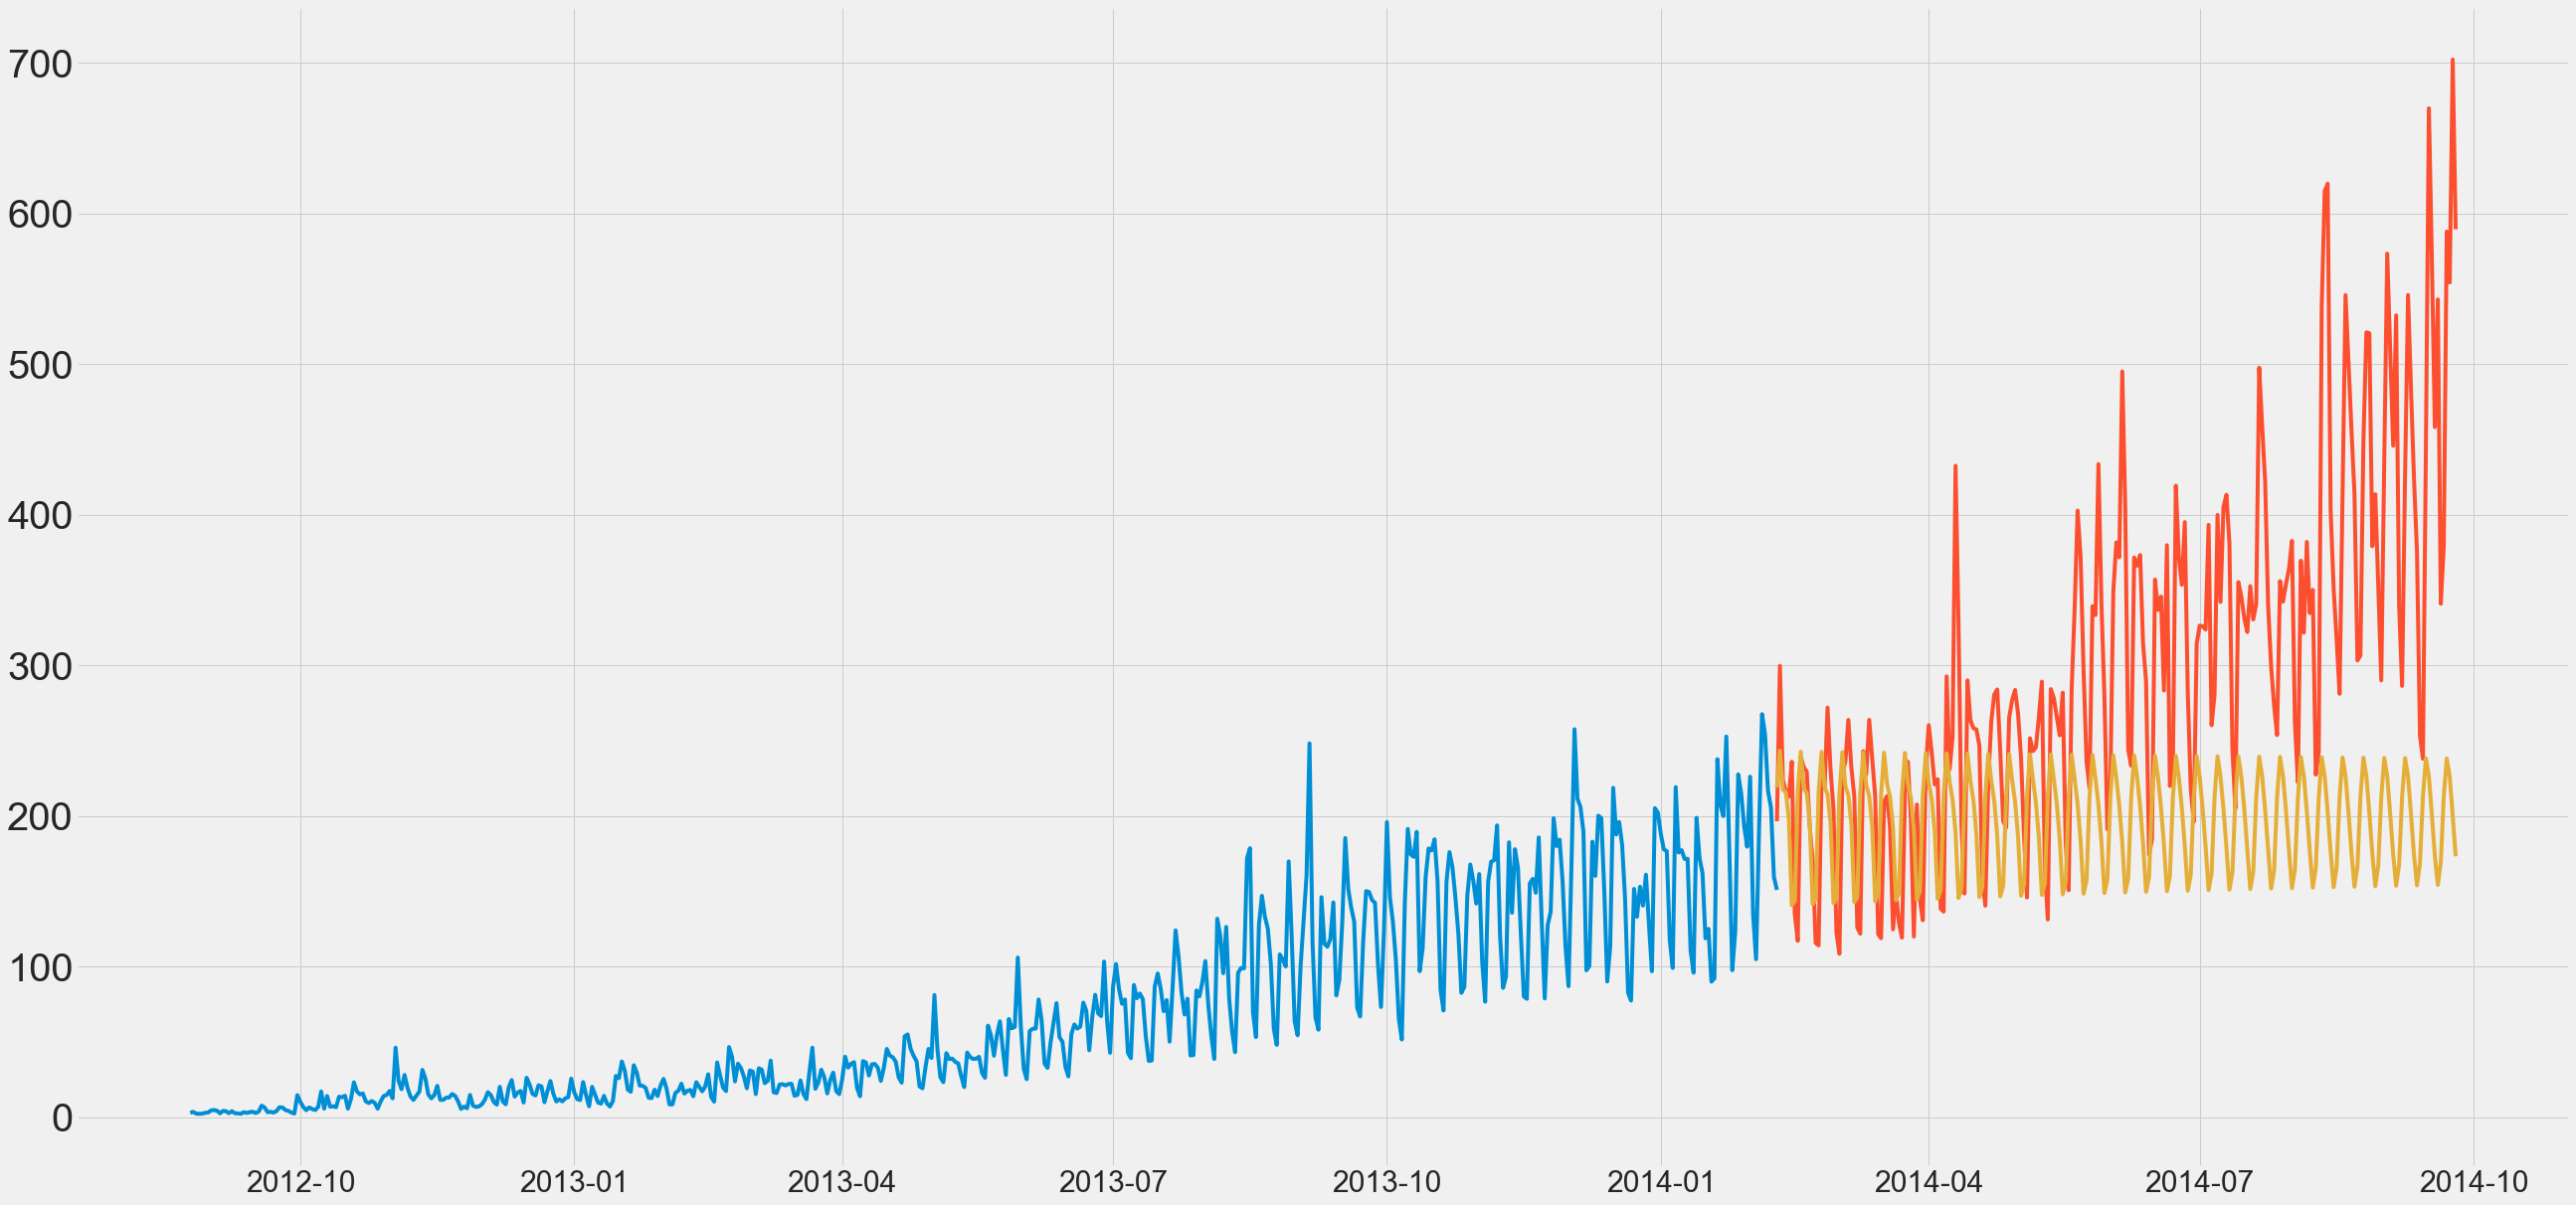

In [43]:
plt.figure(figsize=(40, 20))
plt.plot(X, label='X')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [63]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = AARIMA  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in valid['Count']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Root mean squared error: {np.sqrt(mean_squared_error(valid, forecasts))}")
print(f"SMAPE: {smape(valid, forecasts)}")
# Mean squared error: 
# SMAPE: 

Root mean squared error: 63.242955349792496
SMAPE: 15.206582089478298


No handles with labels found to put in legend.


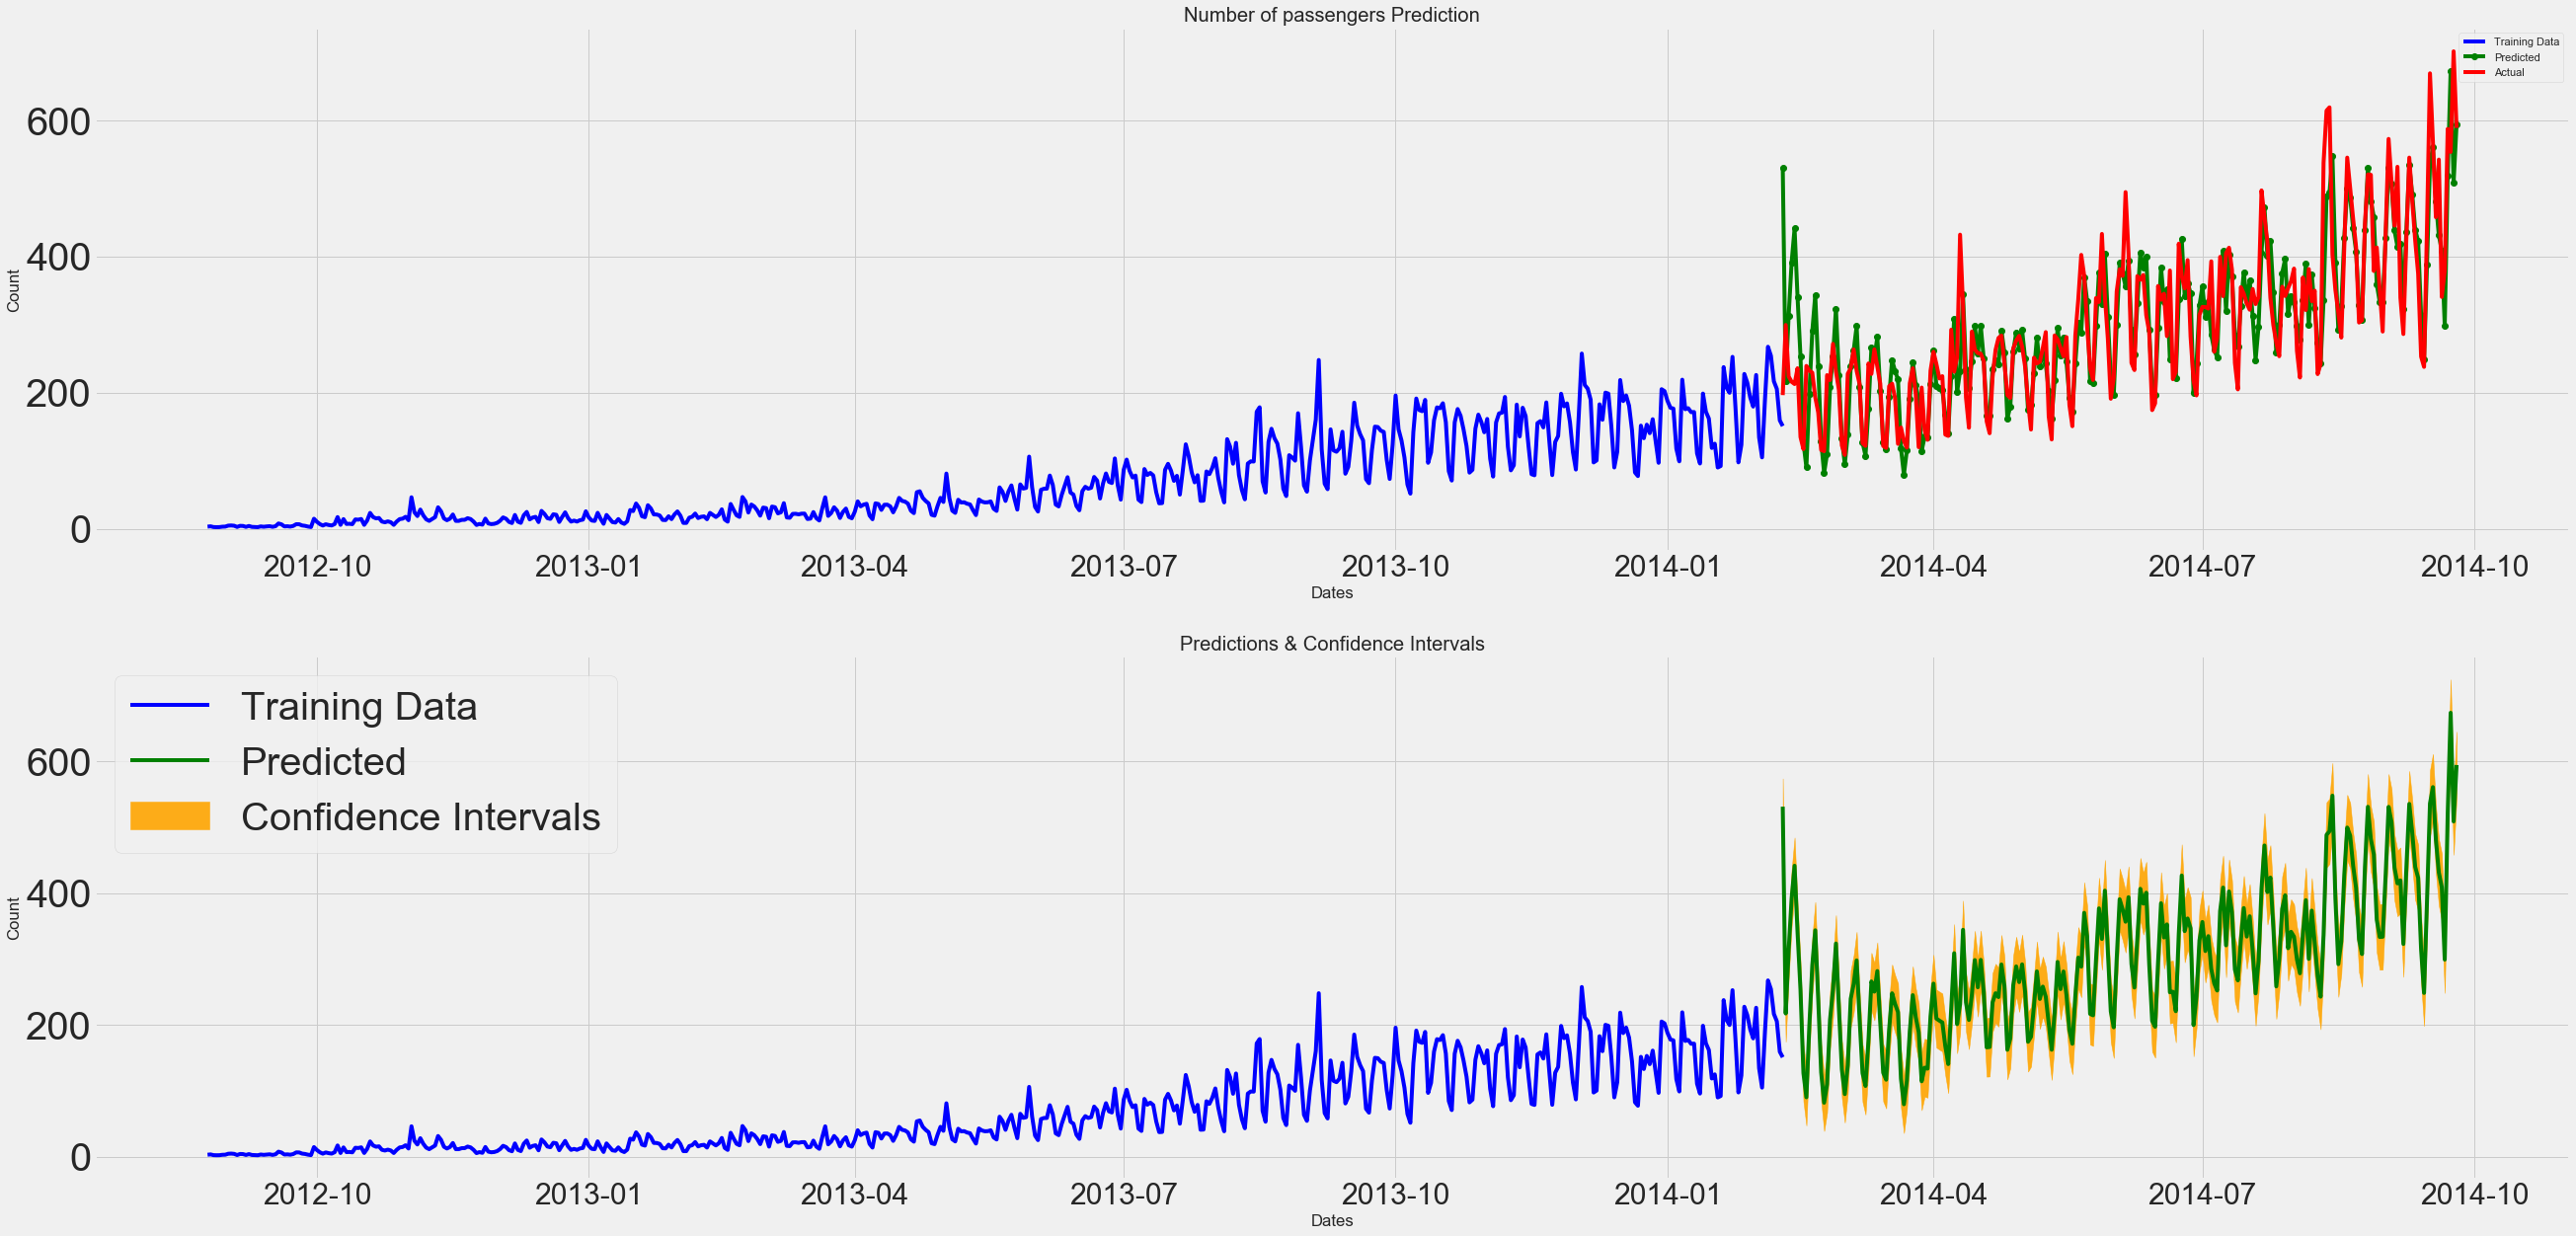

In [72]:
ig, axes = plt.subplots(2, 1, figsize=(40, 20))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(X, color='blue', label='Training Data')
axes[0].plot(valid.index, forecasts, color='green', marker='o',
             label='Predicted')

axes[0].plot(valid.index, valid, color='red', label='Actual')
axes[0].set_title('Number of passengers Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Count')
axes[0].legend(loc='best')
plt.legend(fontsize=40)


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(X, color='blue', label='Training Data')
axes[1].plot(valid.index, forecasts, color='green',
             label='Predicted')

axes[1].set_title('Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Count')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(valid.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].legend()
plt.legend(fontsize=40)
plt.show()

In [2]:
train=pd.read_csv('Train.csv')
test=pd.read_csv('Test.csv')


train.drop(['ID'], axis=1, inplace=True)
test.drop(['ID'], axis=1, inplace=True)

train.Timestamp=pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
train.set_index(['Datetime'], inplace=True)
test.Timestamp=pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
test.set_index(['Datetime'], inplace=True)

In [3]:
import pmdarima as pm
from pmdarima.arima.utils import nsdiffs
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import ndiffs
from sklearn.metrics import mean_squared_error


kpss_diffs = ndiffs(train['Count'], alpha=0.05, test='kpss', max_d=7)
adf_diffs = ndiffs(train['Count'], alpha=0.05, test='adf', max_d=7)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

# estimate number of seasonal differences using a Canova-Hansen test
CH = nsdiffs(train['Count'],
            m=24,  # commonly requires knowledge of dataset
            max_D=24,
            test='ch')  # -> 0

# or use the OCSB test (by default)
OCSB = nsdiffs(train['Count'],
        m=24,
        max_D=24,
        test='ocsb')  # -> 0
ns_diffs= max(CH, OCSB)

print(f"Estimated seasonal differencing term: {ns_diffs}")

Estimated differencing term: 1
Estimated seasonal differencing term: 1


In [ ]:
AARIMA= pm.auto_arima(train, d=n_diffs, trace=False, D=ns_diffs, seasonal=True )
model_fit=AARIMA.fit(train)
forecast=model_fit.predict(n_periods=len(test))
forecast=pd.DataFrame(forecast, index=test.index, columns=['prediction'])
print(AARIMA.order)

In [80]:
submission=pd.read_csv('sample_submission.csv')
submission.head()

,ID,Count
0,18288,0
1,18289,0
2,18290,0
3,18291,0
4,18292,0


In [83]:
print(len(forecast), len(submission))

5112 5112


In [85]:
submission.drop(['Count'], axis=1, inplace=True)
forecast.reset_index(drop=True, inplace=True)
submission['Count']=forecast['prediction']
submission.to_csv('submission.csv', index=False)

,ID
0,18288
1,18289
2,18290
3,18291
4,18292
...,...
5107,23395
5108,23396
5109,23397
5110,23398
